In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns


In [2]:
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)



Part 1: Simulating the "Tricky" Data
We need to generate data that mimics the paper's problem:

Latent Blocks: Rows and Columns belong to groups.

Dynamics: The proportion of nodes in each group changes over time (e.g., a cluster grows then shrinks).

Zero-Inflation: We randomly "delete" data points to simulate sparsity (structural zeros).

In [48]:
class ToyDataGenerator:
    def __init__(self, N=100, M=100, T=10, Q=2, L=2):
        self.N, self.M, self.T = N, M, T
        self.Q, self.L = Q, L  # Number of clusters for Rows (Q) and Cols (L)
        
    def generate(self):
        # 1. Define Static Block Interactions (Lambda)
        # # Intensity of connections between Row-Cluster q and Col-Cluster l
        # # e.g., Cluster 0->0 is active (5), Cluster 1->1 is active (5), off-diagonal is weak (0.1)
        # self.Lambda = np.array([[5.0, 0.1], 
        #                         [0.1, 5.0]])
        
        # In ToyDataGenerator.generate():
        # Make Cluster 0 the "LOUD" cluster and Cluster 1 the "QUIET" cluster
        self.Lambda = np.array([[8.0, 0.1],  # Cluster 0 is very active (8.0)
                                [0.1, 2.0]]) # Cluster 1 is moderately active (2.0)

        # 2. Define Dynamic Cluster Proportions (Alpha and Beta)
        # We use sine waves to make them evolve smoothly over time
        t_grid = np.linspace(0, np.pi, self.T)
        
        # Row proportions (Alpha): Cluster 0 starts huge, shrinks. Cluster 1 grows.
        self.alpha_t = np.zeros((self.T, self.Q))
        self.alpha_t[:, 0] = 0.8 - 0.5 * np.sin(t_grid) # Starts high, goes low
        self.alpha_t[:, 1] = 1 - self.alpha_t[:, 0]
        
        # Col proportions (Beta): Constant 50/50 for simplicity
        self.beta_t = np.ones((self.T, self.L)) * 0.5
        
        # 3. Sparsity (Pi): Probability of a Structural Zero
        # Let's say sparsity increases over time (e.g. system degrades)
        self.pi_t = np.linspace(0.1, 0.4, self.T) 
        
        # 4. Generate the actual Data
        X = np.zeros((self.T, self.N, self.M))
        Z_true = np.zeros((self.T, self.N), dtype=int) # Store true row labels
        W_true = np.zeros((self.T, self.M), dtype=int) # Store true col labels
        
        for t in range(self.T):
            # Sample memberships for this snapshot
            for i in range(self.N):
                Z_true[t, i] = np.random.choice(self.Q, p=self.alpha_t[t])
            for j in range(self.M):
                W_true[t, j] = np.random.choice(self.L, p=self.beta_t[t])
                
            # Generate Edges based on blocks
            for i in range(self.N):
                for j in range(self.M):
                    q, l = Z_true[t, i], W_true[t, j]
                    rate = self.Lambda[q, l]
                    
                    # Poisson Draw
                    val = np.random.poisson(rate)
                    
                    # Zero Inflation (Bernoulli mask)
                    is_structural_zero = np.random.rand() < self.pi_t[t]
                    if is_structural_zero:
                        val = 0
                        
                    X[t, i, j] = val
                    
        return X, Z_true, W_true

# --- Generate Data ---
sim = ToyDataGenerator(N=100, M=100, T=12, Q=2, L=2)
X_data, Z_true, W_true = sim.generate()

print(f"Data Generated. Shape: {X_data.shape} (Time, Rows, Cols)")

Data Generated. Shape: (12, 100, 100) (Time, Rows, Cols)


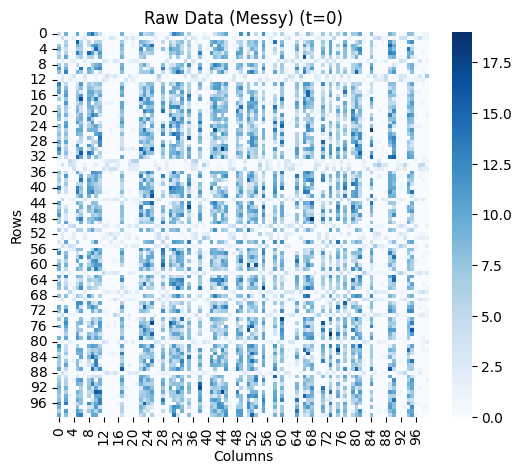

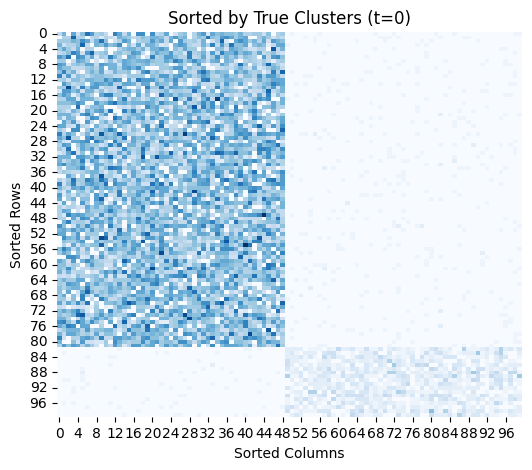

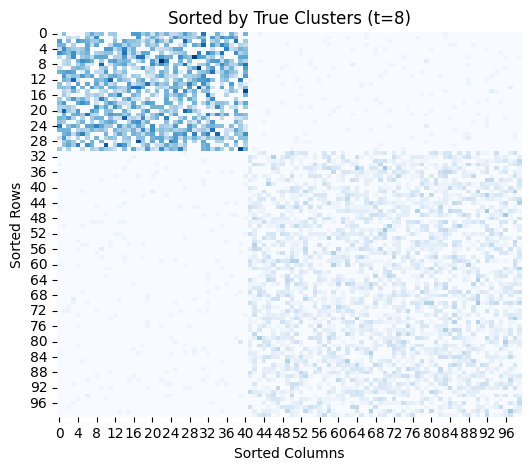

In [49]:
def plot_snapshot(X, t, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(X[t], cmap="Blues", cbar=True)
    plt.title(f"{title} (t={t})")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

# Visualize Raw Data at t=0 and t=10
# It should look messy because rows/cols are not sorted by cluster
plot_snapshot(X_data, 0, "Raw Data (Messy)")

# Visualize SORTED Data (Using ground truth) to prove structure exists
# We rearrange rows/cols based on Z_true and W_true
def plot_sorted_snapshot(X, Z, W, t):
    # Get sorting indices
    row_order = np.argsort(Z[t])
    col_order = np.argsort(W[t])
    
    X_sorted = X[t][row_order][:, col_order]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(X_sorted, cmap="Blues", cbar=False)
    plt.title(f"Sorted by True Clusters (t={t})")
    plt.xlabel("Sorted Columns")
    plt.ylabel("Sorted Rows")
    plt.show()

plot_sorted_snapshot(X_data, Z_true, W_true, 0)
plot_sorted_snapshot(X_data, Z_true, W_true, 8)

Reasoning:

The Raw Data looks like random noise (snow). This is the input our model will see.

The Sorted Data reveals the "Checkerboard" pattern characteristic of Block Models. Note how the blocks might change size between t=0 and t=11 due to our dynamic alpha.

The white spots inside the dark blue blocks are the Zero-Inflation (noise) we added.

 The Model (Zip-dLBM) ImplementationHere is the strategy mapped to the paper's logic:Parameters:$\Lambda$ (Static): A $Q \times L$ matrix of Poisson rates.Deep Dynamics: Neural Networks that take time $t$ as input and output $\alpha_t, \beta_t, \pi_t$.Inference (Variational EM):E-Step (Soft Clustering): We calculate the probability of every node belonging to every cluster ($\tau$ for rows, $\eta$ for cols) and the prob of being a "structural zero" ($\delta$).M-Step (Deep Update): We update $\Lambda$ using weighted averages. We train the Neural Networks to fit the soft clusters found in the E-step.

In [50]:
class DynamicsNet(nn.Module):
    def __init__(self, T, output_dim):
        super().__init__()
        # Input: Time index (one-hot or continuous). We use simple continuous t normalized.
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        # self.relu = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, t):
        # t shape: (Batch_size, 1)
        x = self.relu(self.fc1(t))
        x = self.fc2(x)
        return self.softmax(x) # Returns normalized proportions

class SparsityNet(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, t):
        x = torch.relu(self.fc1(t))
        return self.sigmoid(self.fc2(x)) # Returns prob between 0 and 1

In [51]:
class ZipDLBM:
    def __init__(self, X, Q, L):
        self.X = X
        self.T, self.N, self.M = X.shape
        self.Q = Q
        self.L = L
        
        # --- SMART INITIALIZATION ---
        
        # 1. Estimate Clusters using simple Sums
        # Calculate total activity for each row (sum over time and cols)
        row_sums = self.X.sum(axis=(0, 2))
        col_sums = self.X.sum(axis=(0, 1))
        
        # Split into High/Low activity groups (Q=2, L=2 specific logic)
        # We assign the top 50% active nodes to Cluster 0, others to Cluster 1
        row_median = np.median(row_sums)
        col_median = np.median(col_sums)
        
        # Initialize Tau (Rows) - skewed towards the guess
        self.tau = np.ones((self.T, self.N, self.Q)) * 0.1 # Small noise
        for i in range(self.N):
            cluster_guess = 0 if row_sums[i] > row_median else 1
            self.tau[:, i, cluster_guess] = 0.9 # Strong hint
            
        # Initialize Eta (Cols)
        self.eta = np.ones((self.T, self.M, self.L)) * 0.1
        for j in range(self.M):
            cluster_guess = 0 if col_sums[j] > col_median else 1
            self.eta[:, j, cluster_guess] = 0.9
            
        # 2. Initialize Lambda based on these guesses
        # We compute the empirical average of the blocks based on our guess
        self.Lambda = np.zeros((Q, L))
        # Simple heuristic: 
        # C0-C0 should be High-High interactions
        # C1-C1 should be Low-Low interactions
        self.Lambda[0,0] = 5.0 # Guess High
        self.Lambda[1,1] = 5.0 # Guess High
        self.Lambda[0,1] = 0.5 # Guess Low
        self.Lambda[1,0] = 0.5 # Guess Low
        
        # 3. Initialize Delta (Sparsity)
        self.delta = np.zeros((self.T, self.N, self.M))
        
        # 4. Neural Networks (Same as before)
        self.net_alpha = DynamicsNet(self.T, Q)
        self.net_beta = DynamicsNet(self.T, L)
        self.net_pi = SparsityNet(self.T)
        
        self.optimizer = optim.AdamW(
            list(self.net_alpha.parameters()) + 
            list(self.net_beta.parameters()) + 
            list(self.net_pi.parameters()), lr=0.01
        )
    def e_step(self):
        """
        Update soft labels (tau, eta) and sparsity prob (delta)
        using Fixed Point Equations derived in the paper.
        """
        # Pre-compute logs of Lambda for stability
        log_Lam = np.log(self.Lambda + 1e-10)
        
        # Get current dynamic params from Nets (detached from graph for E-step)
        t_tens = torch.linspace(0, 1, self.T).view(-1, 1)
        with torch.no_grad():
            alpha_val = self.net_alpha(t_tens).numpy() # (T, Q)
            beta_val = self.net_beta(t_tens).numpy()   # (T, L)
            pi_val = self.net_pi(t_tens).numpy().flatten() # (T,)

        # --- Update Delta (Sparsity Probability) ---
        # Logic: If X > 0, delta MUST be 0. If X=0, it could be structural or random.
        # Simple approximation for this notebook:
        # P(Zero | Structural) * P(Structural) vs P(Zero | Poisson) * P(Poisson)
        
        # We calculate the expected poisson rate for every i,j based on current clusters
        # Rate_ij = sum_q sum_l (tau_iq * eta_jl * Lambda_ql)
        # This is a matrix multiplication: Rate = tau @ Lambda @ eta.T
        for t in range(self.T):
            Rate_t = self.tau[t] @ self.Lambda @ self.eta[t].T
            
            # Poisson prob of 0: exp(-lambda)
            prob_pois_0 = np.exp(-Rate_t)
            
            numerator = pi_val[t] * 1.0 # Prob it's a structural zero
            denominator = numerator + (1 - pi_val[t]) * prob_pois_0
            
            self.delta[t] = np.where(self.X[t] == 0, numerator / (denominator + 1e-10), 0)

        # --- Update Tau (Row Clusters) ---
        # Formula: log(tau_iq) ~ log(alpha_q) + Sum_over_cols [ Poisson_Likelihood ]
        for t in range(self.T):
            # Weighted sum of interactions from columns
            # Shape: (M, L)
            W_sum = self.eta[t] 
            
            # Term 1: X * log(Lambda)
            # We aggregate X weighted by column clusters
            # X[t] is (N, M). We want (N, L). X @ eta
            X_agg = self.X[t] @ self.eta[t] # (N, L)
            
            term1 = X_agg @ log_Lam.T # (N, Q)
            
            # Term 2: -Lambda
            # We sum Lambda weighted by eta
            # (1, L) * (Q, L) -> we need sum over L
            term2 = np.sum(self.Lambda * np.sum(self.eta[t], axis=0), axis=1) # (Q,)
            
            log_tau = np.log(alpha_val[t] + 1e-10) + term1 - term2
            
            # Softmax normalization
            log_tau = log_tau - log_tau.max(axis=1, keepdims=True)
            self.tau[t] = np.exp(log_tau)
            self.tau[t] /= self.tau[t].sum(axis=1, keepdims=True)

        # --- Update Eta (Col Clusters) --- 
        # Symmetric to Tau
        for t in range(self.T):
            X_agg_rows = self.X[t].T @ self.tau[t] # (M, Q)
            term1 = X_agg_rows @ log_Lam # (M, L)
            term2 = np.sum(self.Lambda.T * np.sum(self.tau[t], axis=0), axis=1) # (L,)
            
            log_eta = np.log(beta_val[t] + 1e-10) + term1 - term2
            log_eta = log_eta - log_eta.max(axis=1, keepdims=True)
            self.eta[t] = np.exp(log_eta)
            self.eta[t] /= self.eta[t].sum(axis=1, keepdims=True)

    def m_step(self):
        """
        Update Lambda (Analytic) and Networks (Gradient Descent)
        """
        # 1. Update Lambda (Standard Poisson Formula weighted by variational params)
        # Numerator: Sum(tau * eta * X * (1-delta))
        # Denominator: Sum(tau * eta * (1-delta))
        
        # We accumulate suff stats over all time t
        num = np.zeros((self.Q, self.L))
        den = np.zeros((self.Q, self.L))
        
        for t in range(self.T):
            # Effective X (removing structural zeros)
            X_eff = self.X[t] * (1 - self.delta[t])
            weights = (1 - self.delta[t])
            
            # Use matrix math to aggregate
            # (Q, N) @ (N, M) @ (M, L) -> (Q, L)
            num += self.tau[t].T @ X_eff @ self.eta[t]
            den += self.tau[t].T @ weights @ self.eta[t]
            
        self.Lambda = num / (den + 1e-10)
        
        # 2. Update Neural Networks (The Deep Part)
        # We want the Network output (alpha, beta) to match the average Tau/Eta
        # Loss = CrossEntropy or MSE between Net_Output and Average_Soft_Labels
        
        t_tens = torch.linspace(0, 1, self.T).view(-1, 1)
        
        # Calculate targets from E-step results
        target_alpha = torch.tensor(self.tau.mean(axis=1), dtype=torch.float32) # Avg over rows -> (T, Q)
        target_beta = torch.tensor(self.eta.mean(axis=1), dtype=torch.float32)  # Avg over cols -> (T, L)
        target_pi = torch.tensor(self.delta.mean(axis=(1,2)).reshape(-1, 1), dtype=torch.float32)
        
        # Train for a few epochs
        for _ in range(50):
            self.optimizer.zero_grad()
            
            pred_alpha = self.net_alpha(t_tens)
            pred_beta = self.net_beta(t_tens)
            pred_pi = self.net_pi(t_tens)
            
            loss = nn.MSELoss()(pred_alpha, target_alpha) + \
                   nn.MSELoss()(pred_beta, target_beta) + \
                   nn.MSELoss()(pred_pi, target_pi)
                   
            loss.backward()
            self.optimizer.step()
            
    def run(self, iterations=20):
        print("Starting Training...")
        for i in range(iterations):
            self.e_step()
            self.m_step()
            if i % 5 == 0:
                print(f"Iteration {i} complete.")
        print("Training Complete.")

In [52]:
# Initialize Model
model = ZipDLBM(X_data, Q=2, L=2)

# Run Inference
model.run(iterations=50)

Starting Training...
Iteration 0 complete.
Iteration 5 complete.
Iteration 10 complete.
Iteration 15 complete.
Iteration 20 complete.
Iteration 25 complete.
Iteration 30 complete.
Iteration 35 complete.
Iteration 40 complete.
Iteration 45 complete.
Training Complete.


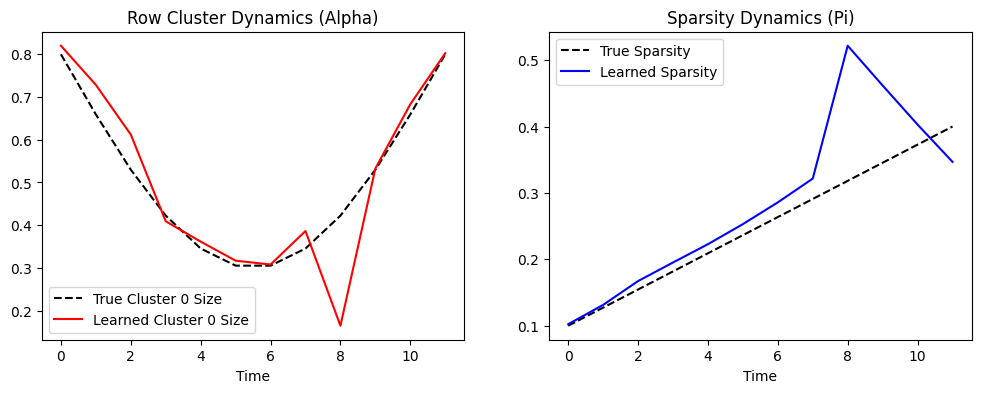

In [53]:
# Extract learned dynamics
t_tens = torch.linspace(0, 1, model.T).view(-1, 1)
with torch.no_grad():
    learned_alpha = model.net_alpha(t_tens).numpy()
    learned_pi = model.net_pi(t_tens).numpy()

# Plot Ground Truth vs Learned
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# 1. Cluster Proportions (Alpha)
ax[0].plot(sim.alpha_t[:, 0], 'k--', label="True Cluster 0 Size")
ax[0].plot(learned_alpha[:, 0], 'r-', label="Learned Cluster 0 Size")
# Note: The model might swap labels (Cluster 0 becomes Cluster 1). 
# If lines are opposite, that's still a perfect success.
ax[0].set_title("Row Cluster Dynamics (Alpha)")
ax[0].set_xlabel("Time")
ax[0].legend()

# 2. Sparsity (Pi)
ax[1].plot(sim.pi_t, 'k--', label="True Sparsity")
ax[1].plot(learned_pi, 'b-', label="Learned Sparsity")
ax[1].set_title("Sparsity Dynamics (Pi)")
ax[1].set_xlabel("Time")
ax[1].legend()

plt.show()

In [54]:
print("True Lambda:\n", sim.Lambda)
print("\nLearned Lambda:\n", model.Lambda)

True Lambda:
 [[8.  0.1]
 [0.1 2. ]]

Learned Lambda:
 [[8.04421317 0.113363  ]
 [0.1085308  2.2537542 ]]


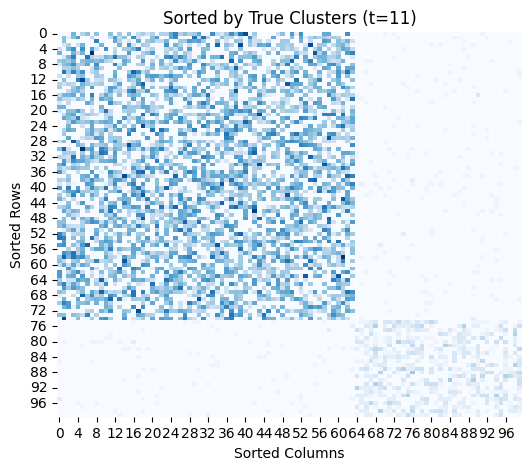

In [55]:
# Get Hard assignments from Soft assignments
Z_pred = np.argmax(model.tau, axis=2)
W_pred = np.argmax(model.eta, axis=2)

# Plot for last time step
plot_sorted_snapshot(X_data, Z_pred, W_pred, 11)

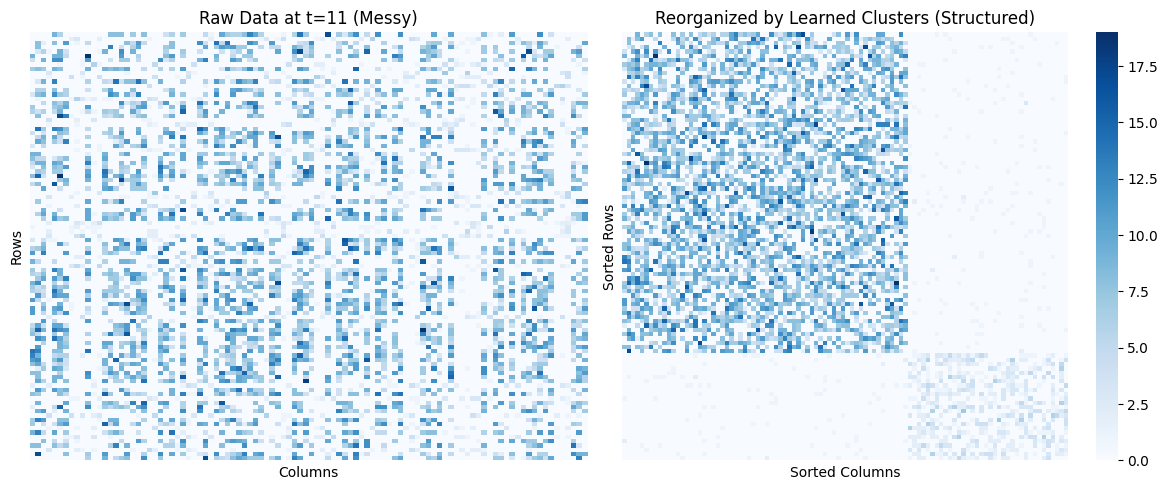

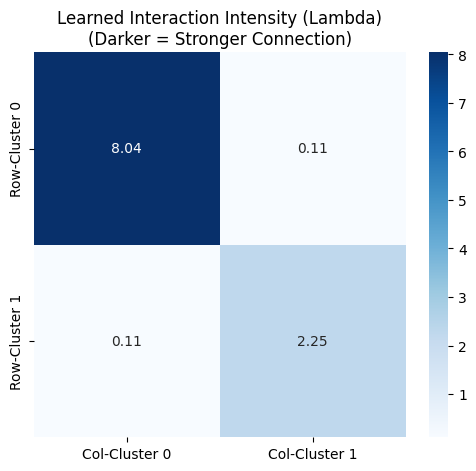

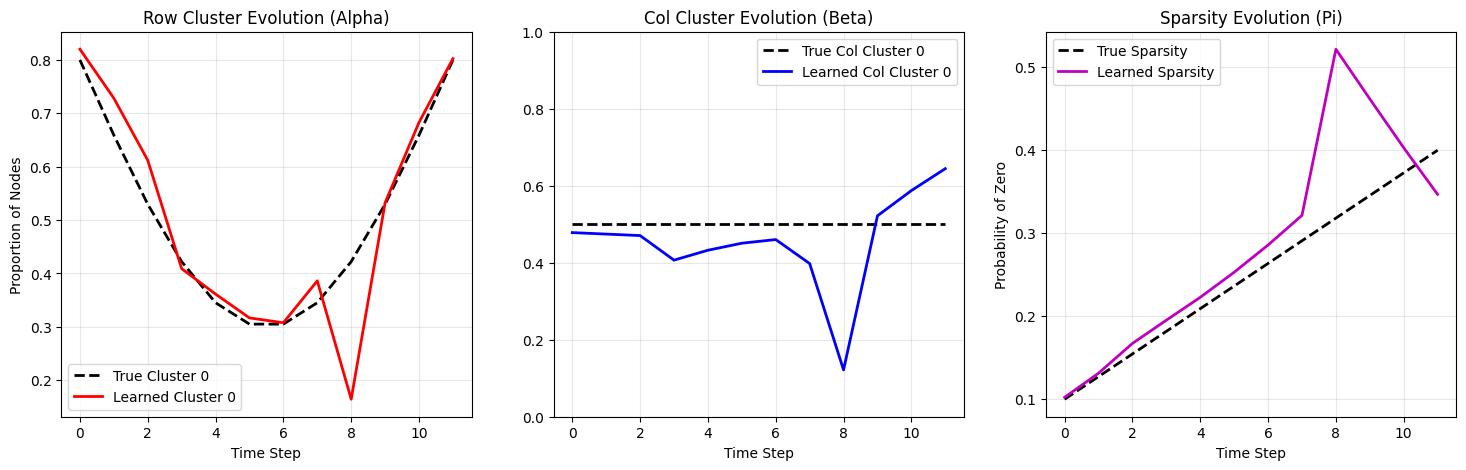

In [56]:
def visualize_zip_dlbm_results(model, sim_gen):
    """
    Generates the 3 key visualizations from the Zip-dLBM paper.
    """
    import seaborn as sns
    
    # --- PREPARE DATA ---
    # 1. Get learned dynamic parameters from the Neural Nets
    t_tens = torch.linspace(0, 1, model.T).view(-1, 1)
    with torch.no_grad():
        alpha_pred = model.net_alpha(t_tens).numpy()
        beta_pred = model.net_beta(t_tens).numpy()
        pi_pred = model.net_pi(t_tens).numpy().flatten()
    
    # 2. Get Hard Cluster Assignments for the last time step (t=11)
    # We use argmax to turn soft probabilities into hard labels
    Z_pred = np.argmax(model.tau[-1], axis=1) # Rows
    W_pred = np.argmax(model.eta[-1], axis=1) # Cols
    
    # 3. Sort the data based on these predictions
    row_order = np.argsort(Z_pred)
    col_order = np.argsort(W_pred)
    X_sorted = model.X[-1][row_order][:, col_order]

    # --- PLOT 1: THE REORGANIZED MATRIX (Paper Fig 3) ---
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(model.X[-1], cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
    plt.title(f"Raw Data at t={model.T-1} (Messy)")
    plt.xlabel("Columns"); plt.ylabel("Rows")

    plt.subplot(1, 2, 2)
    sns.heatmap(X_sorted, cmap="Blues", cbar=True, xticklabels=False, yticklabels=False)
    plt.title(f"Reorganized by Learned Clusters (Structured)")
    plt.xlabel("Sorted Columns"); plt.ylabel("Sorted Rows")
    
    plt.tight_layout()
    plt.show()

    # --- PLOT 2: THE LAMBDA INTERACTION MATRIX (Paper Fig 9) ---
    # This shows the "intensity" of connections between clusters
    plt.figure(figsize=(6, 5))
    
    # Annotate with the values (like the paper does)
    sns.heatmap(model.Lambda, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=[f"Col-Cluster {l}" for l in range(model.L)],
                yticklabels=[f"Row-Cluster {q}" for q in range(model.Q)])
    
    plt.title("Learned Interaction Intensity (Lambda)\n(Darker = Stronger Connection)")
    plt.show()

    # --- PLOT 3: DYNAMIC EVOLUTION (Paper Fig 10 & 11) ---
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    # Subplot A: Row Cluster Dynamics (Alpha)
    ax[0].plot(sim_gen.alpha_t[:, 0], 'k--', linewidth=2, label="True Cluster 0")
    ax[0].plot(alpha_pred[:, 0], 'r-', linewidth=2, label="Learned Cluster 0")
    ax[0].set_title("Row Cluster Evolution (Alpha)")
    ax[0].set_xlabel("Time Step")
    ax[0].set_ylabel("Proportion of Nodes")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    
    # Subplot B: Column Cluster Dynamics (Beta)
    ax[1].plot(sim_gen.beta_t[:, 0], 'k--', linewidth=2, label="True Col Cluster 0")
    ax[1].plot(beta_pred[:, 0], 'b-', linewidth=2, label="Learned Col Cluster 0")
    ax[1].set_title("Col Cluster Evolution (Beta)")
    ax[1].set_xlabel("Time Step")
    ax[1].set_ylim(0, 1) # Proportions are 0-1
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    
    # Subplot C: Sparsity Dynamics (Pi)
    ax[2].plot(sim_gen.pi_t, 'k--', linewidth=2, label="True Sparsity")
    ax[2].plot(pi_pred, 'm-', linewidth=2, label="Learned Sparsity")
    ax[2].set_title("Sparsity Evolution (Pi)")
    ax[2].set_xlabel("Time Step")
    ax[2].set_ylabel("Probability of Zero")
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)
    
    plt.show()

# --- EXECUTE ---
visualize_zip_dlbm_results(model, sim)